In [34]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import joblib
import copy
import pandas as pd
import numpy as np
import os
from time import time
import heapq


PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))
NOTE_ROOT_DIR = os.path.abspath('')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# prepare data 
from sklearn.model_selection import train_test_split, cross_val_predict, RepeatedStratifiedKFold
from sklearn.cluster import OPTICS, DBSCAN, Birch
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.preprocessing import StandardScaler

# model
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# evaluate
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix

lda_table = pd.DataFrame(columns = ['name', 'train_acc', 'train_f1', 'train_roc_auc','test_acc', 'test_f1','test_roc_auc'])
pca_table = pd.DataFrame(columns = ['name', 'train_acc', 'train_f1', 'train_roc_auc','test_acc', 'test_f1','test_roc_auc'])


# Utils

In [35]:
def stratify(df, frac, random_state):
    win_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    win_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    win_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    df_test = pd.concat([win_19_20,lose_19_20,draw_19_20,win_20_21,lose_20_21,draw_20_21,win_21_22,lose_21_22,draw_21_22], axis = 0)
    df_train = pd.concat([df,df_test]).drop_duplicates(keep=False)
    return df_train.iloc[:,:-2], df_test.iloc[:,:-2],df_train.iloc[:,-2] , df_test.iloc[:,-2]

def train_classifier(clf, X, y):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X, y)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    y_pred = cross_val_predict(clf, features, target.squeeze(),cv = 3, method = 'predict_proba')
    y_pred_1 = cross_val_predict(clf, features, target.squeeze(),cv = 3, method = 'predict')
    return f1_score(target.squeeze(), y_pred_1, average='weighted'), accuracy_score(target.squeeze(), y_pred_1), roc_auc_score(target.squeeze(), y_pred, multi_class = 'ovo', average = 'macro')


    
def train_predict(name, clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    global lda_table, pca_table
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1tr, acctr,roctr = predict_labels(clf, X_train, y_train)
    print("F1 score and accuracy score and roc score for training set: {:.4f} , {:.4f} , {:.4f}.".format(f1tr , acctr, roctr))
    
    f1te, accte, rocte = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score and roc score for test set: {:.4f} , {:.4f} , {:.4f}.".format(f1te , accte, rocte))
    if 'lda' in name:
        lda_table = pd.concat([lda_table,pd.DataFrame([[name, acctr,f1tr,roctr,accte,f1te,rocte]], columns = lda_table.columns)])
    else:
        pca_table = pd.concat([pca_table,pd.DataFrame([[name, acctr,f1tr,roctr,accte,f1te,rocte]], columns = lda_table.columns)])

def tuning(clf,param_dict,X_train, y_train, n_iter=50,cv=5,scoring="roc_auc_ovo",random_state=42,verbose=0):
    search_spaces = {}
    for param in clf.get_params().keys():
        if (str(clf.__class__.__name__) +'_'+param) in param_dict.keys():
            search_spaces[param] = param_dict[str(clf.__class__.__name__) +'_'+param]
    if search_spaces == {}:
        return clf
    search = BayesSearchCV(clf, search_spaces, 
                           n_iter=n_iter, cv=cv, scoring=scoring, 
                           random_state=random_state, n_jobs=-1, verbose=verbose)

    search.fit(X_train, y_train.squeeze())
    
    print(str(clf.__class__.__name__) +" best score :", search.best_score_)
    print(str(clf.__class__.__name__) +" best params:", search.best_params_)

    return search

# Setup to save/load the model
def save_model(model, id_):
    print("Saving model", id_)
    joblib.dump(model, os.path.join(NOTE_ROOT_DIR, "models", id_ + ".pkl"))
def load_model(id_):
    print("Loading model", id_)
    return joblib.load(os.path.join(NOTE_ROOT_DIR, "models", id_ + ".pkl"))


## 1. Load data

### LDA Data

In [3]:
df = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "matches.csv"))
para = {'name':'lda', 'eps': 8.5}
df

,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,-100.000000,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,-0.780148,1.990417,-0.727778,-2.796785,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.718124,2.234902,-0.764160,-0.524770,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,-100.000000,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,0.878456,2.518209,-0.529214,-3.471708,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,-1.604356,2.068204,-0.881599,-1.226240,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1136,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-100.000000,-100.000000,-100.000000
1137,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,-100.000000,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,0.762411,1.627330,-1.141200,-1.083433,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000


### PCA Data

In [36]:
df = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","pca", "matches.csv"))
para = {'name':'pca', 'eps': 30}
df

,home_result,season,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,...,14_26,15_26,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26
0,lose,2019/20,-0.833564,11.894702,9.797198,0.690392,-0.399289,-0.196324,-0.271997,1.064701,...,1.037913,0.891078,0.420644,0.077849,-0.069981,-0.705365,0.952756,1.854779,-1.037659,-0.282706
1,win,2019/20,-1.341095,8.727017,7.268857,0.476498,-0.217216,-0.160226,-0.007719,0.360472,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
2,win,2019/20,-0.645374,10.338912,8.351297,0.264416,0.377598,-0.239645,-0.172684,2.751132,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,win,2019/20,-0.455534,15.332285,12.749199,0.857845,-0.496018,-0.299477,-0.234882,0.315938,...,-0.111448,0.046474,0.630581,-1.904343,-0.748645,0.929946,1.764384,0.233507,-0.252928,1.420810
4,win,2019/20,-0.728257,12.335970,9.748855,0.095955,-0.098054,-0.104447,-1.154838,0.704880,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,-0.942070,15.881339,14.056281,1.229575,-1.038763,-1.182373,-1.298392,-1.673618,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1136,win,2021/22,-1.327757,8.190598,6.862505,0.450774,-0.281004,-0.101381,0.100049,0.008824,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1137,lose,2021/22,-1.187595,13.179885,11.210599,0.516861,-0.516988,-0.648351,-0.633078,-1.161408,...,-1.850484,0.279975,1.544454,1.299444,-0.837068,-1.799868,0.270484,2.016364,0.713818,0.394452
1138,win,2021/22,-0.360106,15.206365,11.933520,-0.441674,0.409827,1.008120,-0.185278,-1.363143,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000


### 1.1. Manage Empty Positions' Statistics

In [37]:
for i in df.columns:
    df[i].replace({-100 : min(df[df[i] != -100][i])}, inplace = True)
#     df[i].replace({-100 : 0}, inplace = True)
df


,home_result,season,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,...,14_26,15_26,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26
0,lose,2019/20,-0.833564,11.894702,9.797198,0.690392,-0.399289,-0.196324,-0.271997,1.064701,...,1.037913,0.891078,0.420644,0.077849,-0.069981,-0.705365,0.952756,1.854779,-1.037659,-0.282706
1,win,2019/20,-1.341095,8.727017,7.268857,0.476498,-0.217216,-0.160226,-0.007719,0.360472,...,-7.071041,-1.336412,-2.580456,-5.745477,-2.318469,-4.367482,-2.555427,-4.320019,-1.357529,-3.812818
2,win,2019/20,-0.645374,10.338912,8.351297,0.264416,0.377598,-0.239645,-0.172684,2.751132,...,-7.071041,-1.336412,-2.580456,-5.745477,-2.318469,-4.367482,-2.555427,-4.320019,-1.357529,-3.812818
3,win,2019/20,-0.455534,15.332285,12.749199,0.857845,-0.496018,-0.299477,-0.234882,0.315938,...,-0.111448,0.046474,0.630581,-1.904343,-0.748645,0.929946,1.764384,0.233507,-0.252928,1.420810
4,win,2019/20,-0.728257,12.335970,9.748855,0.095955,-0.098054,-0.104447,-1.154838,0.704880,...,-7.071041,-1.336412,-2.580456,-5.745477,-2.318469,-4.367482,-2.555427,-4.320019,-1.357529,-3.812818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,-0.942070,15.881339,14.056281,1.229575,-1.038763,-1.182373,-1.298392,-1.673618,...,-7.071041,-1.336412,-2.580456,-5.745477,-2.318469,-4.367482,-2.555427,-4.320019,-1.357529,-3.812818
1136,win,2021/22,-1.327757,8.190598,6.862505,0.450774,-0.281004,-0.101381,0.100049,0.008824,...,-7.071041,-1.336412,-2.580456,-5.745477,-2.318469,-4.367482,-2.555427,-4.320019,-1.357529,-3.812818
1137,lose,2021/22,-1.187595,13.179885,11.210599,0.516861,-0.516988,-0.648351,-0.633078,-1.161408,...,-1.850484,0.279975,1.544454,1.299444,-0.837068,-1.799868,0.270484,2.016364,0.713818,0.394452
1138,win,2021/22,-0.360106,15.206365,11.933520,-0.441674,0.409827,1.008120,-0.185278,-1.363143,...,-7.071041,-1.336412,-2.580456,-5.745477,-2.318469,-4.367482,-2.555427,-4.320019,-1.357529,-3.812818


## 2. Scale

In [38]:
df_scale =df[df.columns[2:]]
scaler = StandardScaler()
df_scale=scaler.fit_transform(df[df.columns[2:]])
df_scale = pd.DataFrame(df_scale, columns = df.columns[2:])
df_scale[['result','season'] ] = df[['home_result', 'season']]
df_scale


,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26,result,season
0,-0.245306,-0.211860,-0.194298,0.467300,-0.229997,-0.031500,-0.046727,0.918293,-0.788674,0.968899,...,1.699603,1.503822,1.159867,1.078440,1.868939,2.255398,-0.337064,1.359311,lose,2019/20
1,-0.986257,-0.732120,-0.685103,0.046152,0.109113,0.011514,-0.011964,0.390102,-0.617822,0.639982,...,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009,win,2019/20
2,0.029436,-0.467383,-0.474978,-0.371426,1.216950,-0.083120,-0.033663,2.183163,0.191517,-0.149420,...,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009,win,2019/20
3,0.306584,0.352728,0.378750,0.797006,-0.410155,-0.154414,-0.041845,0.356700,-0.370892,0.045916,...,1.865336,0.774776,0.620855,1.846637,2.442593,1.486016,0.410831,2.324118,win,2019/20
4,-0.091568,-0.139386,-0.203682,-0.703118,0.331051,0.077979,-0.162854,0.648417,-0.773715,0.185198,...,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,-0.403716,0.442905,0.632483,1.528925,-1.421013,-1.206457,-0.181737,-1.135523,-0.717245,1.535012,...,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009,win,2021/22
1136,-0.966784,-0.820221,-0.763985,-0.004496,-0.009692,0.081633,0.002212,0.126356,-0.175843,0.092728,...,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009,win,2021/22
1137,-0.762161,-0.000782,0.080074,0.125627,-0.449211,-0.570127,-0.094223,-0.751351,-0.678004,0.883277,...,2.586792,1.953122,0.550628,0.564290,1.386711,2.332079,1.332198,1.742828,lose,2021/22
1138,0.445902,0.332047,0.220409,-1.761684,1.276975,1.403692,-0.035320,-0.902658,2.230127,-3.056171,...,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009,win,2021/22


## 2.Trainset & Testset

In [39]:
# df = df_scale
# X_train, X_test, y_train, y_test = stratify(df, 0.2,42)

In [40]:
df = df_scale 
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-2]], df['result'], test_size = 0.2, random_state = 42)
y_train = y_train.replace({'lose':0, 'draw': 1, 'win': 2})
y_test = y_test.replace({'lose':0, 'draw': 1, 'win': 2})

In [41]:
print('Train size :',len(X_train))
print('Test size: ', len(X_test))

Train size : 912
Test size:  228


In [42]:
X_train

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,14_26,15_26,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26
12,-0.706523,-0.663057,-0.661295,-0.464134,0.429063,0.208081,-0.120311,-0.513220,-0.180813,-0.114961,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
581,0.372693,0.321712,0.326790,0.722117,-0.389556,0.066235,-0.195721,0.536479,-0.479746,0.486470,...,0.997968,1.807674,-0.007360,1.105008,1.525611,1.126734,0.953217,0.822658,0.261859,0.892430
1003,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,1.586290,0.946913,2.275145,1.683329,1.535338,1.685446,2.089662,1.767069,1.926763,1.813020
501,0.205893,0.286382,0.302137,0.520429,-0.371867,-0.291657,-0.145772,-0.279935,-0.430493,0.698689,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
318,-0.245306,-0.211860,-0.194298,0.467300,-0.229997,-0.031500,-0.046727,0.918293,-0.788674,0.968899,...,0.752175,-0.320228,0.717059,2.394275,1.653784,2.165237,1.314665,0.924025,-0.111233,0.746712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,0.667323,0.349550,1.755867,1.043421,1.026446,1.142223,1.136291,0.759189,1.416786,2.458877
1095,0.445939,0.773048,0.793888,-0.725352,0.113482,0.627040,-0.043644,-0.431000,2.342001,-2.724975,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
1130,0.259392,0.616165,0.716305,1.500154,-0.802466,-0.363552,-0.121643,-0.055501,-0.150988,0.028396,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
860,-2.160428,-1.971225,-1.891115,-0.595244,0.737391,0.345072,-0.035789,0.056691,-0.225465,0.222994,...,2.054692,0.395932,2.176672,1.932346,0.781567,1.048631,1.251832,1.482480,2.623181,2.009104


## 3. Outline removal

### 3.2. Isolation Forest

In [43]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
X_train['anomaly'] = model.fit_predict(X_train)
ano = X_train[X_train['anomaly'] == -1].index
X_train.drop(ano, inplace=True)
X_train.reset_index(inplace = True, drop = True)

y_train.drop(ano, inplace=True)
y_train.reset_index(inplace = True, drop = True)

assert len(X_train) == len(y_train)

X_train = X_train[X_train.columns[:-1]]
X_train

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,14_26,15_26,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26
0,-0.706523,-0.663057,-0.661295,-0.464134,0.429063,0.208081,-0.120311,-0.513220,-0.180813,-0.114961,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
1,0.372693,0.321712,0.326790,0.722117,-0.389556,0.066235,-0.195721,0.536479,-0.479746,0.486470,...,0.997968,1.807674,-0.007360,1.105008,1.525611,1.126734,0.953217,0.822658,0.261859,0.892430
2,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,1.586290,0.946913,2.275145,1.683329,1.535338,1.685446,2.089662,1.767069,1.926763,1.813020
3,0.205893,0.286382,0.302137,0.520429,-0.371867,-0.291657,-0.145772,-0.279935,-0.430493,0.698689,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
4,-0.245306,-0.211860,-0.194298,0.467300,-0.229997,-0.031500,-0.046727,0.918293,-0.788674,0.968899,...,0.752175,-0.320228,0.717059,2.394275,1.653784,2.165237,1.314665,0.924025,-0.111233,0.746712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,0.667323,0.349550,1.755867,1.043421,1.026446,1.142223,1.136291,0.759189,1.416786,2.458877
816,0.445939,0.773048,0.793888,-0.725352,0.113482,0.627040,-0.043644,-0.431000,2.342001,-2.724975,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
817,0.259392,0.616165,0.716305,1.500154,-0.802466,-0.363552,-0.121643,-0.055501,-0.150988,0.028396,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
818,-2.160428,-1.971225,-1.891115,-0.595244,0.737391,0.345072,-0.035789,0.056691,-0.225465,0.222994,...,2.054692,0.395932,2.176672,1.932346,0.781567,1.048631,1.251832,1.482480,2.623181,2.009104


### 3.3. Clustering

In [44]:
X_train['cluster'] = DBSCAN(min_samples=2, eps = para['eps']).fit_predict(X_train)
cls = X_train[X_train['cluster'] == -1].index
X_train.drop(cls, inplace=True)
X_train.reset_index(inplace = True, drop = True)

y_train.drop(cls, inplace=True)
y_train.reset_index(inplace = True, drop = True)

X_train = X_train[X_train.columns[:-1]]
X_train

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,14_26,15_26,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26
0,-0.706523,-0.663057,-0.661295,-0.464134,0.429063,0.208081,-0.120311,-0.513220,-0.180813,-0.114961,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
1,0.372693,0.321712,0.326790,0.722117,-0.389556,0.066235,-0.195721,0.536479,-0.479746,0.486470,...,0.997968,1.807674,-0.007360,1.105008,1.525611,1.126734,0.953217,0.822658,0.261859,0.892430
2,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,1.586290,0.946913,2.275145,1.683329,1.535338,1.685446,2.089662,1.767069,1.926763,1.813020
3,0.205893,0.286382,0.302137,0.520429,-0.371867,-0.291657,-0.145772,-0.279935,-0.430493,0.698689,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
4,-0.245306,-0.211860,-0.194298,0.467300,-0.229997,-0.031500,-0.046727,0.918293,-0.788674,0.968899,...,0.752175,-0.320228,0.717059,2.394275,1.653784,2.165237,1.314665,0.924025,-0.111233,0.746712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,0.667323,0.349550,1.755867,1.043421,1.026446,1.142223,1.136291,0.759189,1.416786,2.458877
802,0.445939,0.773048,0.793888,-0.725352,0.113482,0.627040,-0.043644,-0.431000,2.342001,-2.724975,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
803,0.259392,0.616165,0.716305,1.500154,-0.802466,-0.363552,-0.121643,-0.055501,-0.150988,0.028396,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
804,-2.160428,-1.971225,-1.891115,-0.595244,0.737391,0.345072,-0.035789,0.056691,-0.225465,0.222994,...,2.054692,0.395932,2.176672,1.932346,0.781567,1.048631,1.251832,1.482480,2.623181,2.009104


### 3.4. Boxplot

In [45]:
columns = X_train.columns
upper = []
lower = []
for i in columns :
    
    Q1 = np.percentile(X_train[i], 25,
                       interpolation = 'midpoint')

    Q3 = np.percentile(X_train[i], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    upper += np.where(X_train[i] >= (Q3+1.5*IQR))[0].tolist()
#     print(upper)
    # Lower bound
    lower += np.where(X_train[i] <= (Q1-1.5*IQR))[0].tolist()

    ''' Removing the Outliers '''
index = upper+ lower
frq = [index.count(i) for i in range(len(X_train))]
# print([frq[i] for i in range(len(frq)) if frq[i] in heapq.nlargest(4, set(frq)) ])
bl = [i for i in range(len(frq)) if frq[i] in heapq.nlargest(2, set(frq)) ]
X_train.drop(bl, inplace = True)
X_train.reset_index(inplace = True, drop = True)
y_train.drop(bl, inplace = True)
y_train.reset_index(inplace = True, drop = True)
X_train

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,14_26,15_26,16_26,17_26,18_26,19_26,20_26,21_26,22_26,23_26
0,-0.706523,-0.663057,-0.661295,-0.464134,0.429063,0.208081,-0.120311,-0.513220,-0.180813,-0.114961,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
1,0.372693,0.321712,0.326790,0.722117,-0.389556,0.066235,-0.195721,0.536479,-0.479746,0.486470,...,0.997968,1.807674,-0.007360,1.105008,1.525611,1.126734,0.953217,0.822658,0.261859,0.892430
2,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,1.586290,0.946913,2.275145,1.683329,1.535338,1.685446,2.089662,1.767069,1.926763,1.813020
3,0.205893,0.286382,0.302137,0.520429,-0.371867,-0.291657,-0.145772,-0.279935,-0.430493,0.698689,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
4,-0.245306,-0.211860,-0.194298,0.467300,-0.229997,-0.031500,-0.046727,0.918293,-0.788674,0.968899,...,0.752175,-0.320228,0.717059,2.394275,1.653784,2.165237,1.314665,0.924025,-0.111233,0.746712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0.035475,-0.361932,-0.431583,-0.783161,0.676481,-0.106070,-0.100685,-0.734517,-0.282287,-0.313642,...,0.667323,0.349550,1.755867,1.043421,1.026446,1.142223,1.136291,0.759189,1.416786,2.458877
799,0.445939,0.773048,0.793888,-0.725352,0.113482,0.627040,-0.043644,-0.431000,2.342001,-2.724975,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
800,0.259392,0.616165,0.716305,1.500154,-0.802466,-0.363552,-0.121643,-0.055501,-0.150988,0.028396,...,-0.653672,-0.580906,-0.669610,-0.637986,-0.625939,-0.641863,-0.610631,-0.674880,-0.641919,-0.640009
801,-2.160428,-1.971225,-1.891115,-0.595244,0.737391,0.345072,-0.035789,0.056691,-0.225465,0.222994,...,2.054692,0.395932,2.176672,1.932346,0.781567,1.048631,1.251832,1.482480,2.623181,2.009104


## 6. Model

### 6.2. Attribute selection

In [ ]:
importance = np.zeros((1,len(X_train.columns)))
#     model = XGBClassifier()
model = RandomForestClassifier()
param_dict = {  
    "XGBClassifier_eta": (0.01,0.2,"uniform"),
    "XGBClassifier_min_child_weight": (1,20),
    "XGBClassifier_max_depth": (3,10),
    
    "RandomForestClassifier_n_estimators": (5, 500), 
    "RandomForestClassifier_criterion": ["gini", "entropy"],
    "RandomForestClassifier_max_depth": (1, 19), # 19 overfits the data
    "RandomForestClassifier_min_samples_split": (2, 20),
    "RandomForestClassifier_max_features": [None, "sqrt", "log2"],
    "RandomForestClassifier_max_leaf_nodes": (2, 159),
    "RandomForestClassifier_min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "RandomForestClassifier_max_samples": (0.5, 1.0, "uniform")
}
model_t = tuning(model,param_dict,X_train, y_train)
# fit the model
model_t.best_estimator_.fit(X_train, y_train)
# get importance
importance = model_t.best_estimator_.feature_importances_

# plot feature importance
plt.figure(figsize=(30,40))
plt.bar([x for x in range(len(importance))], [x for x in importance])
plt.show()

thes = float(input('Thres: '))
# summarize feature importance
idx = []
for i,v in enumerate(importance):
    if v > thes :
        idx.append(i)
        print('Feature: %0d, Score: %.5f' % (i,v))
print(len(idx),idx)

In [46]:
corr_target = X_train.corrwith(y_train)
corr_other = X_train.corr()
corr_table = corr_target.subtract(corr_other.mean(axis = 1)) 
attribute = corr_table.nlargest(60)
idx = [list(X_train.columns).index(i) for i in attribute.index]

In [47]:
X_train = X_train[X_train.columns[idx]]
X_test = X_test[X_test.columns[idx]]
X_train

,2_13,23_0,0_13,5_13,16_17,15_13,4_13,16_21,19_1,16_20,...,13_16,12_17,17_22,3_13,21_7,0_12,12_18,8_13,5_11,23_13
0,0.066947,0.602985,-0.121831,0.809882,1.748879,0.551404,0.678176,-0.116422,-0.463717,0.015752,...,-0.074012,0.199138,0.782517,1.822478,0.240377,0.129455,2.129527,1.521602,-0.522739,1.470185
1,-0.544176,-1.627873,-0.597453,-0.540305,-1.238366,-0.584593,-0.622693,-1.006545,-1.266160,-2.318425,...,-0.516954,-0.437856,-1.773912,-0.613475,0.073386,-0.162250,-0.311669,-0.600733,-0.268211,-0.622977
2,0.048865,2.295285,1.174162,0.739773,0.576096,0.878860,-0.203231,0.251164,-0.309786,0.261183,...,0.475834,-0.112610,-1.773912,2.116123,-0.599097,0.824461,0.082151,1.657115,0.685736,1.491907
3,-0.544176,-0.748510,-0.597453,-0.540305,-0.153790,-0.584593,-0.622693,-0.967999,-0.497425,0.236735,...,-0.267473,0.010362,0.892515,-0.613475,-0.707677,0.920286,-0.357785,-0.600733,0.113639,-0.622977
4,-0.544176,-1.017294,-0.597453,-0.540305,0.265529,-0.584593,-0.622693,-0.920521,-0.262369,-0.457545,...,0.398663,-0.981797,-1.773912,-0.613475,-0.193703,-0.996478,0.020204,-0.600733,-0.477195,-0.622977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0.916861,2.295285,1.803668,1.855551,0.979657,2.401507,1.404982,1.223607,-0.309786,0.914473,...,1.570193,0.102381,-1.773912,2.306891,-0.599097,0.922807,0.445695,1.504190,0.216390,1.923587
799,0.233510,0.864811,-0.041905,0.587898,-0.036485,1.357724,1.630828,-0.864789,1.016729,0.138670,...,1.185889,-0.642233,0.161891,1.735068,-0.369351,0.895197,-0.216032,1.382127,-0.081313,1.907290
800,-0.544176,-0.081862,-0.597453,-0.540305,0.506717,-0.584593,-0.622693,1.686733,-0.018883,0.157126,...,0.998212,0.157736,0.090418,-0.613475,-0.034894,-0.024937,0.270350,-0.600733,2.107194,-0.622977
801,-0.544176,-0.350883,-0.597453,-0.540305,-0.178765,-0.584593,-0.622693,1.527883,1.707397,-0.610367,...,1.883106,-0.612939,-1.773912,-0.613475,0.615874,-0.996478,0.568223,-0.600733,-0.335275,-0.622977


### 6.3.Model

#### 6.3.1. Logistic Regression

In [48]:
lr = LogisticRegression(random_state = 42,multi_class="multinomial")
train_predict(para['name']+'_lr_no_tune',lr, X_train, y_train, X_test, y_test)

Training a LogisticRegression using a training set size of 803. . .
Trained model in 0.0752 seconds
F1 score and accuracy score and roc score for training set: 0.5055 , 0.5243 , 0.6479.
F1 score and accuracy score and roc score for test set: 0.4621 , 0.4693 , 0.5786.


#### 6.3.4. Decision Tree

In [49]:
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
train_predict(para['name']+'_dt_no_tune',dt, X_train, y_train, X_test, y_test)

Training a DecisionTreeClassifier using a training set size of 803. . .
Trained model in 0.0456 seconds
F1 score and accuracy score and roc score for training set: 0.4389 , 0.4408 , 0.5687.
F1 score and accuracy score and roc score for test set: 0.4027 , 0.3947 , 0.5359.


#### 6.3.5. Random Forest

In [50]:
rf = RandomForestClassifier(random_state=42)
train_predict(para['name']+'_rf_no_tune',rf, X_train, y_train, X_test, y_test)

Training a RandomForestClassifier using a training set size of 803. . .
Trained model in 0.4716 seconds
F1 score and accuracy score and roc score for training set: 0.4783 , 0.5131 , 0.6356.
F1 score and accuracy score and roc score for test set: 0.4859 , 0.5351 , 0.6115.


#### 6.3.6. Ada Boost

In [51]:
ab = AdaBoostClassifier(learning_rate=0.7, n_estimators=100)
train_predict(para['name']+'_ab_no_tune',ab, X_train, y_train, X_test, y_test)

Training a AdaBoostClassifier using a training set size of 803. . .
Trained model in 0.5977 seconds
F1 score and accuracy score and roc score for training set: 0.4622 , 0.4745 , 0.5898.
F1 score and accuracy score and roc score for test set: 0.4594 , 0.4561 , 0.5595.


#### 6.3.7. Gradient Boosting

In [52]:
gb = GradientBoostingClassifier(learning_rate=0.7, random_state=42)
train_predict(para['name']+'_gb_no_tune',gb, X_train, y_train, X_test, y_test)

Training a GradientBoostingClassifier using a training set size of 803. . .
Trained model in 3.0108 seconds
F1 score and accuracy score and roc score for training set: 0.4318 , 0.4371 , 0.5898.
F1 score and accuracy score and roc score for test set: 0.4647 , 0.4781 , 0.6094.


#### 6.3.8. Support Vector Classification

In [53]:
svc = SVC(probability=True, random_state=42)
train_predict(para['name']+'_svc_no_tune',svc, X_train, y_train, X_test, y_test)

Training a SVC using a training set size of 803. . .
Trained model in 0.3957 seconds
F1 score and accuracy score and roc score for training set: 0.4791 , 0.5342 , 0.6377.
F1 score and accuracy score and roc score for test set: 0.4731 , 0.5351 , 0.6254.


#### 6.3.9. Simple Neural Network

In [54]:
nn = MLPClassifier(random_state=42)
train_predict(para['name']+'_nn_no_tune',nn, X_train, y_train, X_test, y_test)

Training a MLPClassifier using a training set size of 803. . .
Trained model in 1.3398 seconds
F1 score and accuracy score and roc score for training set: 0.4598 , 0.4670 , 0.6117.
F1 score and accuracy score and roc score for test set: 0.4746 , 0.4825 , 0.5988.


### 6.4. Hyperparameter tuning

##### 6.4.0. Parameter

In [55]:
param_dict = {  
    "RandomForestClassifier_n_estimators": (5, 500), 
    "RandomForestClassifier_criterion": ["gini", "entropy"],
    "RandomForestClassifier_max_depth": (1, 19), # 19 overfits the data
    "RandomForestClassifier_min_samples_split": (2, 20),
    "RandomForestClassifier_max_features": [None, "sqrt", "log2"],
    "RandomForestClassifier_max_leaf_nodes": (2, 159),
    "RandomForestClassifier_min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "RandomForestClassifier_max_samples": (0.5, 1.0, "uniform"),
        
    "GradientBoostingClassifier_n_estimators": (2, 100),
    "GradientBoostingClassifier_learning_rate": Real(low=0.001, high=3, prior="uniform"),
    "GradientBoostingClassifier_subsample": Real(low=0.05, high=1.0, prior="uniform"),
    "GradientBoostingClassifier_criterion": ["friedman_mse", "squared_error"],
    "GradientBoostingClassifier_min_samples_split": Real(low=1e-6, high=1.0, prior="uniform"),
    "GradientBoostingClassifier_max_depth": (1, 10),
    "GradientBoostingClassifier_min_impurity_decrease": Real(low=1e-6, high=0.5, prior="uniform"),
    "GradientBoostingClassifier_max_features": [None, "sqrt", "log2"],
    "GradientBoostingClassifier_max_leaf_nodes": (2, 100),
                  
    "AdaBoostClassifier_n_estimators": (2, 500),
    "AdaBoostClassifier_learning_rate": Real(low=0.001, high=3,  prior='uniform'),
                  
    "SVC_C": Real(low=1e-6, high=2, prior="uniform"),
    "SVC_kernel": ["linear", "poly", "rbf", "sigmoid"],
    "SVC_degree": (2, 30),
    "SVC_gamma": ["scale", "auto"]
    }

In [56]:
load = False

#### 6.4.1. Logistic Regression

In [57]:
# load = False
if load ==  True:
    load_model(para['name']+"lr_t")
else:
    lr_t = tuning(lr,param_dict,X_train, y_train)
    save_model(lr_t,para['name']+"lr_t")
train_predict(para['name']+'_lr_tune',lr_t, X_train, y_train, X_test, y_test)

Saving model pcalr_t
Training a LogisticRegression using a training set size of 803. . .
Trained model in 0.0937 seconds
F1 score and accuracy score and roc score for training set: 0.5055 , 0.5243 , 0.6479.
F1 score and accuracy score and roc score for test set: 0.4621 , 0.4693 , 0.5786.


#### 6.4.4. Decision Tree

In [58]:
# load = False
if load ==  True:
    load_model(para['name']+"dt_t")
else:
    dt_t = tuning(dt,param_dict,X_train, y_train)
    save_model(dt_t,para['name']+"dt_t")
train_predict(para['name']+'_dt_tune',dt_t, X_train, y_train, X_test, y_test)

Saving model pcadt_t
Training a DecisionTreeClassifier using a training set size of 803. . .
Trained model in 0.0380 seconds
F1 score and accuracy score and roc score for training set: 0.4389 , 0.4408 , 0.5687.
F1 score and accuracy score and roc score for test set: 0.4027 , 0.3947 , 0.5359.


#### 6.4.5. Random Forest

In [59]:
# load = False
if load == True:
    load_model(para['name']+"rf_t")
else:
    rf_t = tuning(rf,param_dict,X_train, y_train).best_estimator_
    save_model(rf_t,para['name']+"rf_t")
train_predict(para['name']+'_rf_tune',rf_t, X_train, y_train, X_test, y_test)

RandomForestClassifier best score : 0.6601008674977996
RandomForestClassifier best params: OrderedDict([('criterion', 'gini'), ('max_depth', 11), ('max_features', 'log2'), ('max_leaf_nodes', 95), ('max_samples', 1.0), ('min_impurity_decrease', 1e-06), ('min_samples_split', 19), ('n_estimators', 333)])
Saving model pcarf_t
Training a RandomForestClassifier using a training set size of 803. . .
Trained model in 1.0557 seconds
F1 score and accuracy score and roc score for training set: 0.4751 , 0.5380 , 0.6502.
F1 score and accuracy score and roc score for test set: 0.4705 , 0.5307 , 0.6328.


#### 6.4.6. Ada Boost

In [60]:
# load = False
if load ==  True:
    load_model(para['name']+"ab_t")
else:
    ab_t = tuning(ab,param_dict,X_train, y_train).best_estimator_
    save_model(ab_t,para['name']+"ab_t")
train_predict(para['name']+'_ab_tune',ab_t, X_train, y_train, X_test, y_test)

AdaBoostClassifier best score : 0.6378638730893963
AdaBoostClassifier best params: OrderedDict([('learning_rate', 0.38197224320103196), ('n_estimators', 33)])
Saving model pcaab_t
Training a AdaBoostClassifier using a training set size of 803. . .
Trained model in 0.1718 seconds
F1 score and accuracy score and roc score for training set: 0.4842 , 0.5243 , 0.6191.
F1 score and accuracy score and roc score for test set: 0.4366 , 0.4430 , 0.5756.


#### 6.4.7. Gradient Boosting

In [61]:
# load = False
if load ==  True:
    load_model(para['name']+"gb_t")
else:
    gb_t = tuning(gb,param_dict,X_train, y_train).best_estimator_
    save_model(gb_t,para['name']+"gb_t")
train_predict(para['name']+'_gb_tune',gb_t, X_train, y_train, X_test, y_test)

GradientBoostingClassifier best score : 0.6540190849237436
GradientBoostingClassifier best params: OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.08422516343968713), ('max_depth', 4), ('max_features', 'log2'), ('max_leaf_nodes', 2), ('min_impurity_decrease', 0.5), ('min_samples_split', 0.2308419606212057), ('n_estimators', 100), ('subsample', 0.8460255309812806)])
Saving model pcagb_t
Training a GradientBoostingClassifier using a training set size of 803. . .
Trained model in 0.4313 seconds
F1 score and accuracy score and roc score for training set: 0.4704 , 0.5218 , 0.6378.
F1 score and accuracy score and roc score for test set: 0.4641 , 0.5000 , 0.6568.


#### 6.4.8. Support Vector Classification

In [62]:
# load = False
if load ==  True:
    load_model(para['name']+"svc_t")
else:
    svc_t = tuning(svc,param_dict,X_train, y_train).best_estimator_
    save_model(svc_t,para['name']+"svc_t")
train_predict(para['name']+'_svc_tune',svc_t, X_train, y_train, X_test, y_test)

SVC best score : 0.6705763641679134
SVC best params: OrderedDict([('C', 1.0355239892234074), ('degree', 2), ('gamma', 'auto'), ('kernel', 'sigmoid')])
Saving model pcasvc_t
Training a SVC using a training set size of 803. . .
Trained model in 0.3135 seconds
F1 score and accuracy score and roc score for training set: 0.4800 , 0.5305 , 0.6461.
F1 score and accuracy score and roc score for test set: 0.4566 , 0.5132 , 0.6157.


#### 6.4.9. Simple Neural Network

In [63]:
# load = False
if load ==  True:
    load_model(para['name']+"nn_t")
else:
    nn_t = tuning(nn,param_dict,X_train, y_train)
    save_model(nn_t,para['name']+"nn_t")
train_predict(para['name']+'_nn_tune',nn_t, X_train, y_train, X_test, y_test)

Saving model pcann_t
Training a MLPClassifier using a training set size of 803. . .
Trained model in 1.2651 seconds
F1 score and accuracy score and roc score for training set: 0.4598 , 0.4670 , 0.6117.
F1 score and accuracy score and roc score for test set: 0.4746 , 0.4825 , 0.5988.


## 7. Summary

### LDA

In [29]:
lda_table

,name,train_acc,train_f1,train_roc_auc,test_acc,test_f1,test_roc_auc
0,lda_lr_no_tune,0.453901,0.443623,0.579740,0.368421,0.365658,0.505462
0,lda_dt_no_tune,0.425532,0.422332,0.573069,0.359649,0.358452,0.509734
0,lda_rf_no_tune,0.472340,0.433104,0.588921,0.434211,0.392799,0.545707
0,lda_ab_no_tune,0.391489,0.386204,0.527309,0.381579,0.364188,0.469982
0,lda_gb_no_tune,0.436879,0.428946,0.562570,0.399123,0.391955,0.536533
0,lda_svc_no_tune,0.483688,0.409752,0.593052,0.482456,0.424410,0.529019
0,lda_nn_no_tune,0.421277,0.411050,0.578335,0.416667,0.400416,0.536119
0,lda_lr_tune,0.453901,0.443623,0.579740,0.368421,0.365658,0.505462
0,lda_dt_tune,0.425532,0.422332,0.573069,0.359649,0.358452,0.509734
0,lda_rf_tune,0.475177,0.417916,0.610979,0.469298,0.422879,0.553680


In [32]:
print(classification_report(y_test, rf_t.predict(X_test), target_names=["lose","draw","win"]))

              precision    recall  f1-score   support

        lose       0.57      0.51      0.53        91
        draw       0.00      0.00      0.00        49
         win       0.48      0.75      0.58        88

    accuracy                           0.49       228
   macro avg       0.35      0.42      0.37       228
weighted avg       0.41      0.49      0.44       228



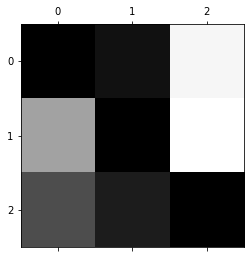

In [33]:

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
conf_mx = confusion_matrix(y, rf_t.predict(X))
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

### PCA

In [64]:
pca_table

,name,train_acc,train_f1,train_roc_auc,test_acc,test_f1,test_roc_auc
0,pca_lr_no_tune,0.524284,0.505453,0.647944,0.469298,0.462140,0.578592
0,pca_dt_no_tune,0.440847,0.438932,0.568745,0.394737,0.402709,0.535946
0,pca_rf_no_tune,0.513076,0.478348,0.635592,0.535088,0.485950,0.611477
0,pca_ab_no_tune,0.474471,0.462211,0.589781,0.456140,0.459398,0.559463
0,pca_gb_no_tune,0.437111,0.431809,0.589822,0.478070,0.464664,0.609363
0,pca_svc_no_tune,0.534247,0.479147,0.637699,0.535088,0.473091,0.625430
0,pca_nn_no_tune,0.466999,0.459837,0.611726,0.482456,0.474640,0.598754
0,pca_lr_tune,0.524284,0.505453,0.647944,0.469298,0.462140,0.578592
0,pca_dt_tune,0.440847,0.438932,0.568745,0.394737,0.402709,0.535946
0,pca_rf_tune,0.537983,0.475121,0.650222,0.530702,0.470498,0.632766


In [72]:
print(classification_report(y_test, rf_t.predict(X_test), target_names=["draw", "lose", "win"]))

              precision    recall  f1-score   support

        draw       0.55      0.52      0.53        91
        lose       0.00      0.00      0.00        49
         win       0.51      0.81      0.62        88

    accuracy                           0.52       228
   macro avg       0.35      0.44      0.39       228
weighted avg       0.42      0.52      0.45       228



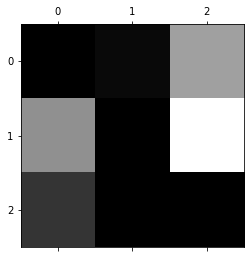

In [68]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
conf_mx = confusion_matrix(y, rf_t.predict(X))
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)